YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data found for TWTR. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data found for FB. Skipping...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data found for ZNGA. Skipping...


[*********************100%***********************]  1 of 1 completed


Start Training!
Environment: TradingSystem_v0, Algorithm: DQN, Device: cpu
Episode: 10/200, Reward: 4.398496020726955
Episode: 20/200, Reward: 4.690381012504426
Episode: 30/200, Reward: 5.643887489933348
Episode: 40/200, Reward: 5.329096396466813
Episode: 50/200, Reward: 5.983611343847073
Episode: 60/200, Reward: 6.9094618528204785
Episode: 70/200, Reward: 4.741188758119578
Episode: 80/200, Reward: 2.041987634389951
Episode: 90/200, Reward: 9.30409455642032
Episode: 100/200, Reward: 4.822673044743698
Episode: 110/200, Reward: 6.198832772973831
Episode: 120/200, Reward: 6.697278664152663
Episode: 130/200, Reward: 5.096132009019305
Episode: 140/200, Reward: 6.253685021803728
Episode: 150/200, Reward: 2.3355572833928413
Episode: 160/200, Reward: 9.88799980254676
Episode: 170/200, Reward: 3.6183156552067324
Episode: 180/200, Reward: 9.136916653982869
Episode: 190/200, Reward: 8.913075438101952
Episode: 200/200, Reward: 5.130935310831684
Finish Training!


<ipython-input-1-82bcc5e85add>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_net.load_state_dict(torch.load(os.path.join(path, 'dqn_checkpoint.pth')))


Start Testing!
Environment: TradingSystem_v0, Algorithm: DQN, Device: cpu
Episode: 1/9, Reward: 9.0
Episode: 2/9, Reward: 9.2
Episode: 3/9, Reward: 5.8
Episode: 4/9, Reward: 11.3
Episode: 5/9, Reward: 10.1
Episode: 6/9, Reward: 9.4
Episode: 7/9, Reward: 3.6
Episode: 8/9, Reward: 2.2
Episode: 9/9, Reward: 2.6
Finish Testing!


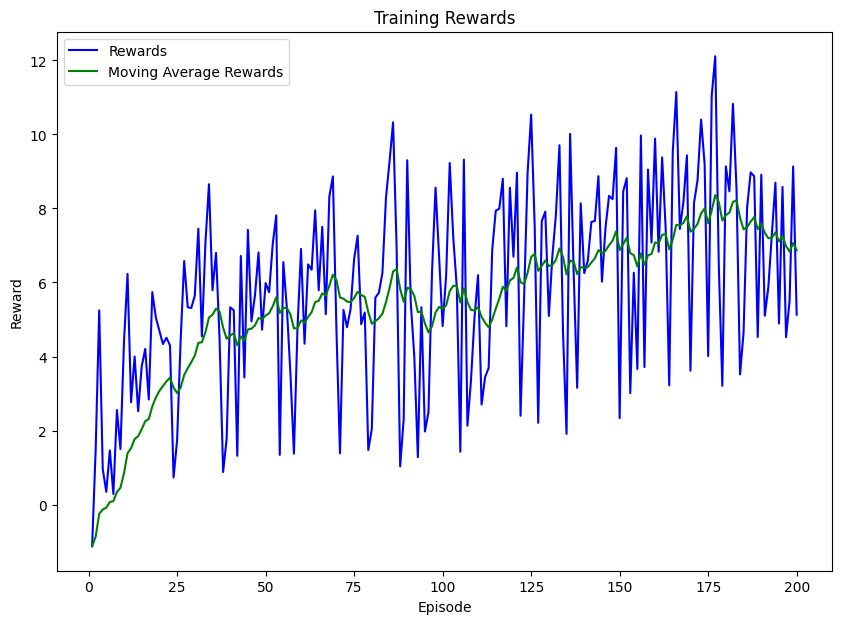

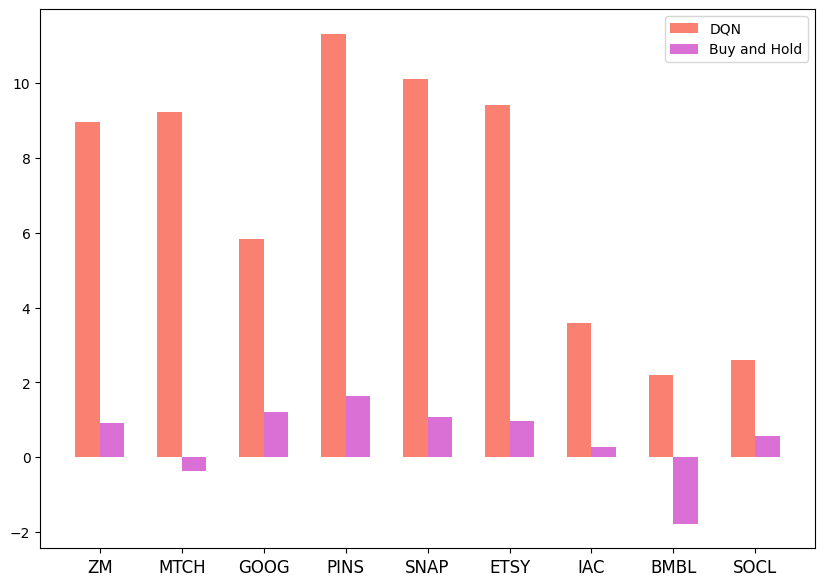

In [ ]:
# Author: Sreejeet Maity
import os
import sys
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ======================== Neural Network Model ========================
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)  # input layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # hidden layer
        self.fc3 = nn.Linear(hidden_dim, action_dim)  # output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ======================== Replay Buffer ========================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        """Stores a transition in the buffer."""
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# ======================== DQN Agent ========================
class DQN:
    def __init__(self, state_dim, action_dim, cfg):
        self.action_dim = action_dim
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.frame_idx = 0
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
                                         (cfg.epsilon_start - cfg.epsilon_end) * \
                                         math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size

        self.policy_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state_tensor = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state_tensor)
                action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_dim)
        return action

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)

        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)  # gradient clipping
        self.optimizer.step()

    def save(self, path):
        torch.save(self.target_net.state_dict(), os.path.join(path, 'dqn_checkpoint.pth'))

    def load(self, path):
        self.target_net.load_state_dict(torch.load(os.path.join(path, 'dqn_checkpoint.pth')))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)

# ======================== Trading Environment ========================
class TradingSystem_v0:
    def __init__(self, returns_data, k_value, mode):
        """
        returns_data: dict of {ticker: returns_series}
        k_value: length of state (lookback window)
        mode: 'train' or 'test'
        """
        self.mode = mode
        self.index = 0
        self.data = returns_data
        self.tickers = list(returns_data.keys())
        self.current_stock = self.tickers[self.index]
        self.r_ts = self.data[self.current_stock]
        self.k = k_value
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.initial_state = tuple(self.r_ts[:self.k])
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def step(self, action):
        """
        action: 0 (short), 1 (neutral), 2 (long)
        Reward is computed as (action - 1) * return.
        """
        self.current_step += 1
        if self.current_step == self.total_steps:
            self.is_terminal = True
        # Multiply the selected return by (action-1)
        self.reward = (action - 1) * self.r_ts[self.current_step + self.k - 1]
        self.state = tuple(self.r_ts[self.current_step:(self.k + self.current_step)])
        return self.state, self.reward, self.is_terminal

    def reset(self):
        if self.mode == 'train':
            self.current_stock = random.choice(self.tickers)
        else:
            self.current_stock = self.tickers[self.index]
            self.index += 1
        self.r_ts = self.data[self.current_stock]
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.initial_state = tuple(self.r_ts[:self.k])
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

# ======================== Configuration ========================
class Config:
    def __init__(self):
        # Environment hyperparameters
        self.algo_name = 'DQN'
        self.env_name = 'TradingSystem_v0'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 11
        self.train_eps = 200
        self.state_space_dim = 50  # lookback window length
        self.action_space_dim = 3  # actions: short (0), neutral (1), long (2)

        # Algorithm hyperparameters
        self.gamma = 0.95
        self.epsilon_start = 0.90
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001
        self.memory_capacity = 1000
        self.batch_size = 64
        self.target_update = 4
        self.hidden_dim = 128

        # Save paths for results and models
        curr_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        try:
            curr_path = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            curr_path = os.getcwd()  # fallback for interactive environments
        self.result_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "results")
        self.model_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "models")
        self.save = True  # whether to save the outputs

# ======================== Environment and Agent Setup ========================
def env_agent_config(data, cfg, mode):
    env = TradingSystem_v0(data, cfg.state_space_dim, mode)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    if cfg.seed != 0:
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)
        random.seed(cfg.seed)
    return env, agent

# ======================== Training Loop ========================
def train(cfg, env, agent):
    print('Start Training!')
    print(f'Environment: {cfg.env_name}, Algorithm: {cfg.algo_name}, Device: {cfg.device}')
    rewards = []
    ma_rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            agent.update()
            ep_reward += reward
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"Episode: {i_ep+1}/{cfg.train_eps}, Reward: {ep_reward}")
    print('Finish Training!')
    return rewards, ma_rewards

# ======================== Testing Loop ========================
def test(cfg, env, agent):
    print('Start Testing!')
    print(f'Environment: {cfg.env_name}, Algorithm: {cfg.algo_name}, Device: {cfg.device}')
    # Disable exploration during testing
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0
    stocks = env.tickers
    rewards = []
    for i_ep in range(len(stocks)):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        print(f"Episode: {i_ep+1}/{len(stocks)}, Reward: {ep_reward:.1f}")
    print('Finish Testing!')
    return stocks, rewards

# ======================== Main Script ========================
if __name__ == "__main__":
    # Define tickers and time range for training and testing
    train_tickers = ['ZM', 'TWTR', 'FB', 'MTCH', 'GOOG', 'PINS', 'SNAP', 'ETSY']
    test_tickers = ['IAC', 'ZNGA', 'BMBL', 'SOCL']
    start_date = dt.date(2020, 1, 1)
    end_date = dt.datetime.today().strftime('%Y-%m-%d')

    # Download training data with error handling
    train_data = {}
    for ticker in train_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        # Use .flatten() to ensure a flat list of returns
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        train_data[ticker] = returns

    # Download testing data with error handling
    test_data = {}
    for ticker in test_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        test_data[ticker] = returns

    # Create configuration, directories, and initialize environment/agent
    cfg = Config()
    os.makedirs(cfg.result_path, exist_ok=True)
    os.makedirs(cfg.model_path, exist_ok=True)

    # Training
    env, agent = env_agent_config(train_data, cfg, mode='train')
    rewards, ma_rewards = train(cfg, env, agent)
    agent.save(path=cfg.model_path)

    # Plot training results
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(range(1, cfg.train_eps + 1), rewards, label='Rewards', color='blue')
    ax.plot(range(1, cfg.train_eps + 1), ma_rewards, label='Moving Average Rewards', color='green')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Training Rewards')
    ax.legend()
    plt.savefig(os.path.join(cfg.result_path, 'train.jpg'))

    # Testing
    all_data = {**train_data, **test_data}
    env, agent = env_agent_config(all_data, cfg, mode='test')
    agent.load(path=cfg.model_path)
    stocks, test_rewards = test(cfg, env, agent)
    buy_and_hold_rewards = [sum(all_data[stock]) for stock in stocks]

    # Plot testing results
    fig, ax = plt.subplots(figsize=(10, 7))
    width = 0.3
    x = np.arange(len(stocks))
    ax.bar(x, test_rewards, width=width, label='DQN', color='salmon')
    ax.bar(x + width, buy_and_hold_rewards, width=width, label='Buy and Hold', color='orchid')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(stocks, fontsize=12)
    ax.legend()
    plt.savefig(os.path.join(cfg.result_path, 'test.jpg'))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data found for TWTR. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data found for FB. Skipping...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')


No data found for ZNGA. Skipping...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Episode: 10/200, Reward: 0.23
Episode: 20/200, Reward: 0.53
Episode: 30/200, Reward: -0.08
Episode: 40/200, Reward: 0.63
Episode: 50/200, Reward: 1.54
Episode: 60/200, Reward: -0.04
Episode: 70/200, Reward: 0.74
Episode: 80/200, Reward: 1.34
Episode: 90/200, Reward: 0.06
Episode: 100/200, Reward: -0.10
Episode: 110/200, Reward: 0.56
Episode: 120/200, Reward: -0.39
Episode: 130/200, Reward: 0.37
Episode: 140/200, Reward: 1.63
Episode: 150/200, Reward: -0.15
Episode: 160/200, Reward: 0.88
Episode: 170/200, Reward: 2.22
Episode: 180/200, Reward: 0.99
Episode: 190/200, Reward: 0.40
Episode: 200/200, Reward: -0.28


<ipython-input-1-26bd5028fdd8>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_net.load_state_dict(torch.load(os.path.join(path, 'dqn_checkpoint.pth')))


Start Testing!
Test Episode: 1/9, Reward: 0.89
Test Episode: 2/9, Reward: 0.75
Test Episode: 3/9, Reward: 0.11
Test Episode: 4/9, Reward: 0.30
Test Episode: 5/9, Reward: 1.45
Test Episode: 6/9, Reward: 2.14
Test Episode: 7/9, Reward: 0.11
Test Episode: 8/9, Reward: 0.89
Test Episode: 9/9, Reward: 0.23


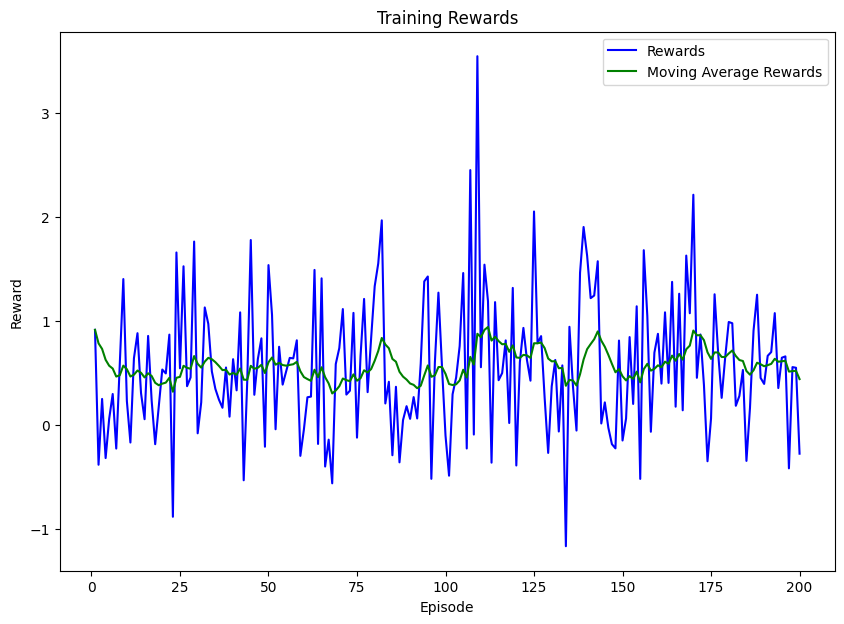

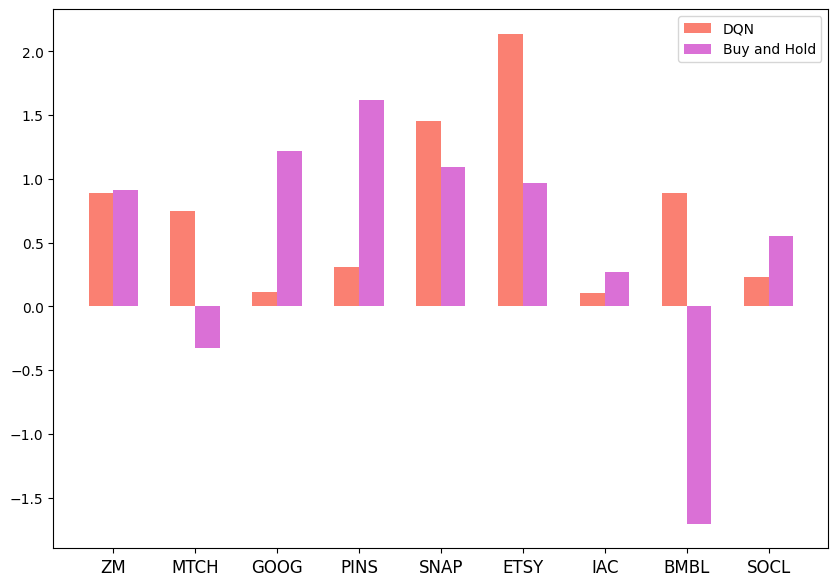

In [ ]:
# Author: Sreejeet Maity
import os
import sys
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ======================== Neural Network Model ========================
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ======================== Replay Buffer ========================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# ======================== DQN Agent ========================
class DQN:
    def __init__(self, state_dim, action_dim, cfg):
        self.action_dim = action_dim
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.frame_idx = 0
        self.epsilon = lambda frame_idx: cfg.epsilon_end + (cfg.epsilon_start - cfg.epsilon_end) * math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size

        self.policy_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state_tensor = torch.tensor([state], device=self.device, dtype=torch.float32)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)

        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def save(self, path):
        torch.save(self.target_net.state_dict(), os.path.join(path, 'dqn_checkpoint.pth'))

    def load(self, path):
        self.target_net.load_state_dict(torch.load(os.path.join(path, 'dqn_checkpoint.pth')))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)

# ======================== Trading Environment with Corrupted Rewards ========================
class TradingSystem_v1:
    def __init__(self, returns_data, k_value, mode, rho=0.1, corruption_type='random'):
        """
        Parameters:
        - returns_data: dict of {ticker: returns_series}
        - k_value: length of state (lookback window)
        - mode: 'train' or 'test'
        - rho: probability that the observed reward is corrupted
        - corruption_type: type of corruption ('random', 'flipped', 'scaled')
        """
        self.mode = mode
        self.index = 0
        self.data = returns_data
        self.tickers = list(returns_data.keys())
        self.current_stock = self.tickers[self.index]
        self.r_ts = self.data[self.current_stock]
        self.k = k_value
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.state = tuple(self.r_ts[:self.k])
        self.reward = 0.0
        self.is_terminal = False
        self.rho = 0.1
        self.corruption_type = corruption_type

    def corrupt_reward(self, true_reward):
        corruption_methods = {
            'random': lambda: random.uniform(-1, 1),
            'flipped': lambda: -3*true_reward,
            'scaled': lambda: true_reward * random.uniform(0.5, 1.5)
        }
        return corruption_methods.get(self.corruption_type, lambda: true_reward)()

    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
            self.is_terminal = True
        # Compute the true reward: (action-1) * return
        true_reward = (action - 1) * self.r_ts[self.current_step + self.k - 1]
        # With probability rho, corrupt the reward
        if random.random() < self.rho:
            self.reward = self.corrupt_reward(true_reward)
        else:
            self.reward = true_reward
        # Update state (using a sliding window)
        self.state = tuple(self.r_ts[self.current_step:(self.k + self.current_step)])
        return self.state, self.reward, self.is_terminal

    def reset(self):
        if self.mode == 'train':
            self.current_stock = random.choice(self.tickers)
        else:
            self.current_stock = self.tickers[self.index]
            self.index += 1
        self.r_ts = self.data[self.current_stock]
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.state = tuple(self.r_ts[:self.k])
        self.reward = 0.0
        self.is_terminal = False
        return self.state

# ======================== Configuration ========================
class Config:
    def __init__(self):
        self.algo_name = 'DQN'
        self.env_name = 'TradingSystem_v1'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 11
        self.train_eps = 200
        self.state_space_dim = 50  # lookback window length
        self.action_space_dim = 3  # actions: short (0), neutral (1), long (2)

        self.gamma = 0.95
        self.epsilon_start = 0.90
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001
        self.memory_capacity = 1000
        self.batch_size = 64
        self.target_update = 4
        self.hidden_dim = 128

        # Set the corruption parameters here:
        self.rho = 0.1  # 20% chance to observe a corrupted reward
        self.corruption_type = 'flipped'  # flip the sign of the true reward when corrupted

        curr_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        try:
            curr_path = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            curr_path = os.getcwd()
        self.result_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "results")
        self.model_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "models")
        self.save = True

# ======================== Environment and Agent Setup ========================
def env_agent_config(data, cfg, mode):
    env = TradingSystem_v1(data, cfg.state_space_dim, mode, rho=cfg.rho, corruption_type=cfg.corruption_type)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    if cfg.seed != 0:
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)
        random.seed(cfg.seed)
    return env, agent

# ======================== Training Loop ========================
def train(cfg, env, agent):
    rewards = []
    ma_rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            agent.update()
            ep_reward += reward
            state = next_state
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"Episode: {i_ep+1}/{cfg.train_eps}, Reward: {ep_reward:.2f}")
    return rewards, ma_rewards

# ======================== Testing Loop ========================
def test(cfg, env, agent):
    print("Start Testing!")
    # Disable exploration during testing
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0
    stocks = env.tickers
    rewards = []
    for i_ep in range(len(stocks)):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break
        rewards.append(ep_reward)
        print(f"Test Episode: {i_ep+1}/{len(stocks)}, Reward: {ep_reward:.2f}")
    return stocks, rewards

# ======================== Main Script ========================
if __name__ == "__main__":
    # Define tickers and time range for training and testing
    train_tickers = ['ZM', 'TWTR', 'FB', 'MTCH', 'GOOG', 'PINS', 'SNAP', 'ETSY']
    test_tickers = ['IAC', 'ZNGA', 'BMBL', 'SOCL']
    start_date = dt.date(2020, 1, 1)
    end_date = dt.datetime.today().strftime('%Y-%m-%d')

    # Download training data
    train_data = {}
    for ticker in train_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        train_data[ticker] = returns

    # Download testing data
    test_data = {}
    for ticker in test_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        test_data[ticker] = returns

    # Combine train and test data for the testing environment
    all_data = {**train_data, **test_data}

    # Create configuration, directories, and initialize environment/agent for training
    cfg = Config()
    os.makedirs(cfg.result_path, exist_ok=True)
    os.makedirs(cfg.model_path, exist_ok=True)

    # Training
    env, agent = env_agent_config(train_data, cfg, mode='train')
    rewards, ma_rewards = train(cfg, env, agent)
    agent.save(path=cfg.model_path)

    # Plot training results
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, cfg.train_eps + 1), rewards, label='Rewards', color='blue')
    plt.plot(range(1, cfg.train_eps + 1), ma_rewards, label='Moving Average Rewards', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.savefig(os.path.join(cfg.result_path, 'train.jpg'))

    # Testing
    env, agent = env_agent_config(all_data, cfg, mode='test')
    agent.load(path=cfg.model_path)
    stocks, test_rewards = test(cfg, env, agent)
    buy_and_hold_rewards = [sum(all_data[stock]) for stock in stocks]

    # Plot testing results
    plt.figure(figsize=(10, 7))
    width = 0.3
    x = np.arange(len(stocks))
    plt.bar(x, test_rewards, width=width, label='DQN', color='salmon')
    plt.bar(x + width, buy_and_hold_rewards, width=width, label='Buy and Hold', color='orchid')
    plt.xticks(x + width / 2, stocks, fontsize=12)
    plt.legend()
    plt.savefig(os.path.join(cfg.result_path, 'test.jpg'))


In [ ]:
def univariate_trimmed_mean(Z, Z_tilde, epsilon, delta):
    M = len(Z) + len(Z_tilde)
    assert len(Z) == len(Z_tilde) == M // 2, "Z and Z_tilde must both have M/2 elements."

    # Step 1: Set ζ = 8ε + 24 log(4/δ) / M
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M
    zeta = min(zeta, 1)  # Ensure ζ does not exceed 1

    # Step 2: Compute quantiles γ and β
    Z_sorted = np.sort(Z)
    gamma_index = int(np.floor(zeta * (M // 2)))
    beta_index = int(np.floor((1 - zeta) * (M // 2)))

    gamma_index = min(gamma_index, len(Z_sorted) - 1)  # Ensure the index is within bounds
    beta_index = min(beta_index, len(Z_sorted) - 1)    # Ensure the index is within bounds

    gamma = Z_sorted[gamma_index]
    beta = Z_sorted[beta_index]

    # Step 3: Compute robust mean estimate
    def phi_gamma_beta(x, gamma, beta):
        if x > beta:
            return beta
        elif x < gamma:
            return gamma
        else:
            return x

    trimmed_sum = sum(phi_gamma_beta(x, gamma, beta) for x in Z_tilde)
    hat_mu_T = (2 / M) * trimmed_sum

    return hat_mu_T

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data found for TWTR. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data found for FB. Skipping...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


No data found for ZNGA. Skipping...


[*********************100%***********************]  1 of 1 completed


Episode: 10/200, Reward: 3.10
Episode: 20/200, Reward: 0.39
Episode: 30/200, Reward: 2.01
Episode: 40/200, Reward: 2.80
Episode: 50/200, Reward: 0.30
Episode: 60/200, Reward: 1.43
Episode: 70/200, Reward: -0.57
Episode: 80/200, Reward: 0.37
Episode: 90/200, Reward: 0.72
Episode: 100/200, Reward: 0.18
Episode: 110/200, Reward: 1.20
Episode: 120/200, Reward: 1.75
Episode: 130/200, Reward: 0.09
Episode: 140/200, Reward: 0.81
Episode: 150/200, Reward: 0.71
Episode: 160/200, Reward: 1.09
Episode: 170/200, Reward: -0.17
Episode: 180/200, Reward: 0.73
Episode: 190/200, Reward: 1.13
Episode: 200/200, Reward: 0.72
Start Testing!
Test Episode: 1/9, Reward: 0.28
Test Episode: 2/9, Reward: 0.87
Test Episode: 3/9, Reward: -0.15
Test Episode: 4/9, Reward: 0.94
Test Episode: 5/9, Reward: 2.01
Test Episode: 6/9, Reward: -0.36
Test Episode: 7/9, Reward: -0.17
Test Episode: 8/9, Reward: 0.09
Test Episode: 9/9, Reward: 0.51


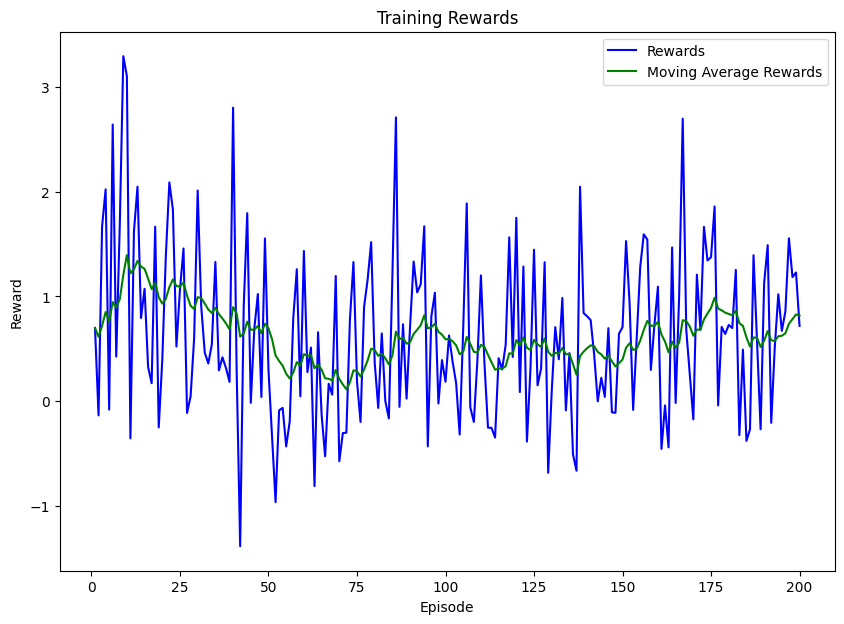

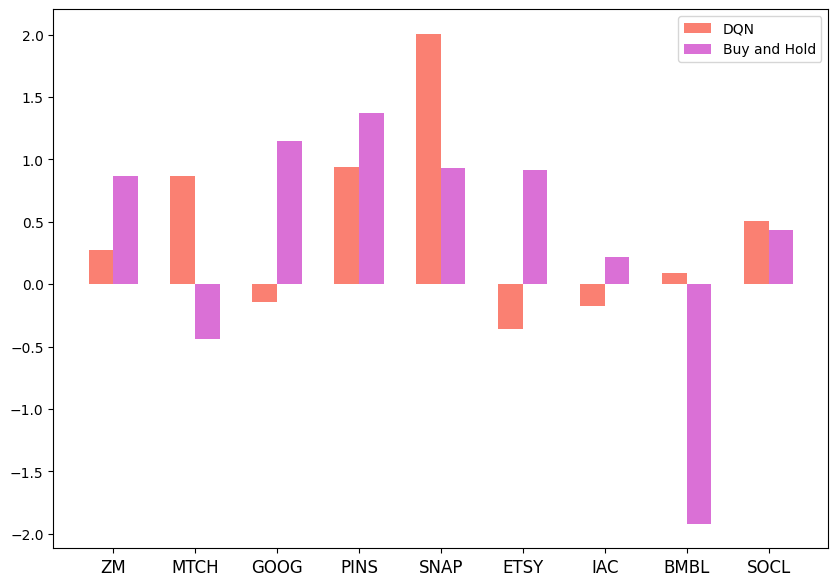

In [ ]:
# Author: Sreejeet Maity
import os
import sys
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ======================== Robust Trimmed Mean Estimator ========================
def univariate_trimmed_mean(Z, Z_tilde, epsilon, delta):
    """
    Robust reward estimator based on trimmed mean.

    Parameters:
    - Z: list of reward observations used for quantile estimation (length M/2)
    - Z_tilde: list of reward observations for averaging (length M/2)
    - epsilon: contamination parameter
    - delta: probability parameter

    Returns:
    - hat_mu_T: robust mean estimate
    """
    M = len(Z) + len(Z_tilde)
    assert len(Z) == len(Z_tilde) == M // 2, "Z and Z_tilde must both have M/2 elements."

    # Step 1: Set ζ = 8ε + 24 log(4/δ) / M
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M
    zeta = min(zeta, 1)  # Ensure ζ does not exceed 1

    # Step 2: Compute quantiles γ and β
    Z_sorted = np.sort(Z)
    gamma_index = int(np.floor(zeta * (M // 2)))
    beta_index = int(np.floor((1 - zeta) * (M // 2)))
    gamma_index = min(gamma_index, len(Z_sorted) - 1)
    beta_index = min(beta_index, len(Z_sorted) - 1)
    gamma = Z_sorted[gamma_index]
    beta = Z_sorted[beta_index]

    # Step 3: Compute robust mean estimate
    def phi_gamma_beta(x, gamma, beta):
        return min(max(x, gamma), beta)

    trimmed_sum = sum(phi_gamma_beta(x, gamma, beta) for x in Z_tilde)
    hat_mu_T = (2 / M) * trimmed_sum
    return hat_mu_T

# ======================== Neural Network Model ========================
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ======================== Replay Buffer ========================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# ======================== DQN Agent ========================
class DQN:
    def __init__(self, state_dim, action_dim, cfg):
        self.action_dim = action_dim
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.frame_idx = 0
        self.epsilon = lambda frame_idx: cfg.epsilon_end + (cfg.epsilon_start - cfg.epsilon_end) * math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size

        self.policy_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)

        # Robust reward estimation buffers:
        # For each (state, action), we maintain two buffers of recent rewards.
        self.Z = {}         # Buffer for quantile estimation (list)
        self.Z_tilde = {}   # Buffer for averaging (list)
        self.robust_buffer_len = 10  # number of rewards to collect before estimating robust reward
        self.robust_epsilon = 0.1    # contamination parameter for robust estimator
        self.robust_delta = 0.1      # delta parameter for robust estimator

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state_tensor = torch.tensor([state], device=self.device, dtype=torch.float32)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)

        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def save(self, path):
        torch.save(self.target_net.state_dict(), os.path.join(path, 'dqn_checkpoint.pth'))

    def load(self, path):
        self.target_net.load_state_dict(torch.load(os.path.join(path, 'dqn_checkpoint.pth')))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)

# ======================== Trading Environment with Corrupted Rewards ========================
class TradingSystem_v1:
    def __init__(self, returns_data, k_value, mode, rho=0.1, corruption_type='random'):
        """
        Parameters:
        - returns_data: dict of {ticker: returns_series}
        - k_value: length of state (lookback window)
        - mode: 'train' or 'test'
        - rho: probability that the observed reward is corrupted
        - corruption_type: type of corruption ('random', 'flipped', 'scaled')
        """
        self.mode = mode
        self.index = 0
        self.data = returns_data
        self.tickers = list(returns_data.keys())
        self.current_stock = self.tickers[self.index]
        self.r_ts = self.data[self.current_stock]
        self.k = k_value
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.state = tuple(self.r_ts[:self.k])
        self.reward = 0.0
        self.is_terminal = False
        self.rho = 0.1
        self.corruption_type = corruption_type

    def corrupt_reward(self, true_reward):
        corruption_methods = {
            'random': lambda: random.uniform(-1, 1),
            'flipped': lambda: -3 * true_reward,
            'scaled': lambda: true_reward * random.uniform(0.5, 1.5)
        }
        return corruption_methods.get(self.corruption_type, lambda: true_reward)()

    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
            self.is_terminal = True
        # Compute the true reward: (action-1) * return
        true_reward = (action - 1) * self.r_ts[self.current_step + self.k - 1]
        # With probability rho, corrupt the reward
        if random.random() < self.rho:
            self.reward = self.corrupt_reward(true_reward)
        else:
            self.reward = true_reward
        # Update state (using a sliding window)
        self.state = tuple(self.r_ts[self.current_step:(self.k + self.current_step)])
        return self.state, self.reward, self.is_terminal

    def reset(self):
        if self.mode == 'train':
            self.current_stock = random.choice(self.tickers)
        else:
            self.current_stock = self.tickers[self.index]
            self.index += 1
        self.r_ts = self.data[self.current_stock]
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.state = tuple(self.r_ts[:self.k])
        self.reward = 0.0
        self.is_terminal = False
        return self.state

# ======================== Configuration ========================
class Config:
    def __init__(self):
        self.algo_name = 'DQN'
        self.env_name = 'TradingSystem_v1'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 11
        self.train_eps = 200
        self.state_space_dim = 50  # lookback window length
        self.action_space_dim = 3  # actions: short (0), neutral (1), long (2)

        self.gamma = 0.95
        self.epsilon_start = 0.90
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001
        self.memory_capacity = 1000
        self.batch_size = 64
        self.target_update = 4
        self.hidden_dim = 128

        # Set the corruption parameters here:
        self.rho = 0.1  # probability to observe a corrupted reward
        self.corruption_type = 'flipped'  # flip the sign of the true reward when corrupted

        curr_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        try:
            curr_path = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            curr_path = os.getcwd()
        self.result_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "results")
        self.model_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "models")
        self.save = True

# ======================== Environment and Agent Setup ========================
def env_agent_config(data, cfg, mode):
    env = TradingSystem_v1(data, cfg.state_space_dim, mode, rho=cfg.rho, corruption_type=cfg.corruption_type)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    if cfg.seed != 0:
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)
        random.seed(cfg.seed)
    return env, agent

# ======================== Training Loop ========================
def train(cfg, env, agent):
    rewards = []
    ma_rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            # --- Robust Reward Estimation using Univariate Trimmed Mean ---
            # We maintain two buffers per (state, action) pair.
            key = (tuple(state), action)
            if key not in agent.Z:
                agent.Z[key] = []
                agent.Z_tilde[key] = []
            agent.Z[key].append(reward)
            agent.Z_tilde[key].append(reward)
            # Truncate buffers to maintain fixed size
            if len(agent.Z[key]) > agent.robust_buffer_len:
                agent.Z[key] = agent.Z[key][-agent.robust_buffer_len:]
                agent.Z_tilde[key] = agent.Z_tilde[key][-agent.robust_buffer_len:]
            # Compute robust reward only when the buffer is full;
            # otherwise, fallback to raw reward.
            if len(agent.Z[key]) == agent.robust_buffer_len:
                robust_reward = univariate_trimmed_mean(agent.Z[key], agent.Z_tilde[key],
                                                        agent.robust_epsilon, agent.robust_delta)
            else:
                robust_reward = reward
            # -------------------------------------------------------------

            agent.memory.push(state, action, robust_reward, next_state, done)
            agent.update()
            ep_reward += reward  # (Logging raw reward; robust_reward is used in learning)
            state = next_state
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"Episode: {i_ep+1}/{cfg.train_eps}, Reward: {ep_reward:.2f}")
    return rewards, ma_rewards

# ======================== Testing Loop ========================
def test(cfg, env, agent):
    print("Start Testing!")
    # Disable exploration during testing
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0
    stocks = env.tickers
    rewards = []
    for i_ep in range(len(stocks)):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break
        rewards.append(ep_reward)
        print(f"Test Episode: {i_ep+1}/{len(stocks)}, Reward: {ep_reward:.2f}")
    return stocks, rewards

# ======================== Main Script ========================
if __name__ == "__main__":
    # Define tickers and time range for training and testing
    train_tickers = ['ZM', 'TWTR', 'FB', 'MTCH', 'GOOG', 'PINS', 'SNAP', 'ETSY']
    test_tickers = ['IAC', 'ZNGA', 'BMBL', 'SOCL']
    start_date = dt.date(2020, 1, 1)
    end_date = dt.datetime.today().strftime('%Y-%m-%d')

    # Download training data
    train_data = {}
    for ticker in train_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        train_data[ticker] = returns

    # Download testing data
    test_data = {}
    for ticker in test_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        test_data[ticker] = returns

    # Combine train and test data for the testing environment
    all_data = {**train_data, **test_data}

    # Create configuration, directories, and initialize environment/agent for training
    cfg = Config()
    os.makedirs(cfg.result_path, exist_ok=True)
    os.makedirs(cfg.model_path, exist_ok=True)

    # Training
    env, agent = env_agent_config(train_data, cfg, mode='train')
    rewards, ma_rewards = train(cfg, env, agent)
    agent.save(path=cfg.model_path)

    # Plot training results
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, cfg.train_eps + 1), rewards, label='Rewards', color='blue')
    plt.plot(range(1, cfg.train_eps + 1), ma_rewards, label='Moving Average Rewards', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.savefig(os.path.join(cfg.result_path, 'train.jpg'))

    # Testing
    env, agent = env_agent_config(all_data, cfg, mode='test')
    agent.load(path=cfg.model_path)
    stocks, test_rewards = test(cfg, env, agent)
    buy_and_hold_rewards = [sum(all_data[stock]) for stock in stocks]

    # Plot testing results
    plt.figure(figsize=(10, 7))
    width = 0.3
    x = np.arange(len(stocks))
    plt.bar(x, test_rewards, width=width, label='DQN', color='salmon')
    plt.bar(x + width, buy_and_hold_rewards, width=width, label='Buy and Hold', color='orchid')
    plt.xticks(x + width / 2, stocks, fontsize=12)
    plt.legend()
    plt.savefig(os.path.join(cfg.result_path, 'test.jpg'))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: YFTzMissingError('possibly delisted; no timezone found')


No data found for TWTR. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('possibly delisted; no timezone found')


No data found for FB. Skipping...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZNGA']: YFTzMissingError('possibly delisted; no timezone found')


No data found for ZNGA. Skipping...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Episode: 10/200, Reward: 6.35
Episode: 20/200, Reward: 2.46
Episode: 30/200, Reward: 7.65
Episode: 40/200, Reward: 10.79
Episode: 50/200, Reward: 6.81
Episode: 60/200, Reward: 4.64
Episode: 70/200, Reward: 4.70
Episode: 80/200, Reward: 3.88
Episode: 90/200, Reward: 2.93
Episode: 100/200, Reward: 8.73
Episode: 110/200, Reward: 9.59
Episode: 120/200, Reward: 8.62
Episode: 130/200, Reward: 7.92
Episode: 140/200, Reward: 10.64
Episode: 150/200, Reward: 10.11
Episode: 160/200, Reward: 10.17
Episode: 170/200, Reward: 12.12
Episode: 180/200, Reward: 3.21
Episode: 190/200, Reward: 8.80
Episode: 200/200, Reward: 7.73
Start Testing!
Test Episode: 1/9, Reward: 9.39
Test Episode: 2/9, Reward: 8.92
Test Episode: 3/9, Reward: 2.51
Test Episode: 4/9, Reward: 10.67
Test Episode: 5/9, Reward: 11.28
Test Episode: 6/9, Reward: 10.41
Test Episode: 7/9, Reward: 2.66
Test Episode: 8/9, Reward: 2.02
Test Episode: 9/9, Reward: 1.91


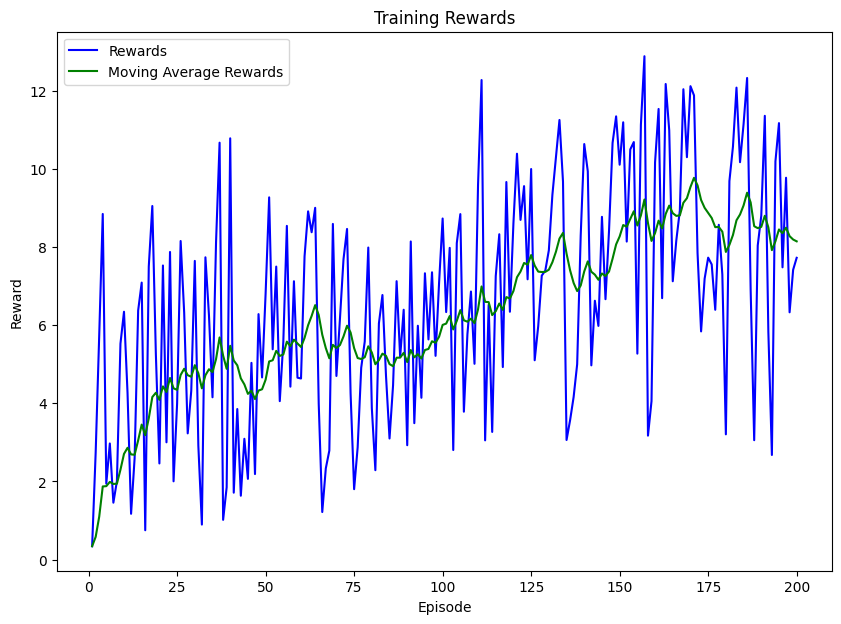

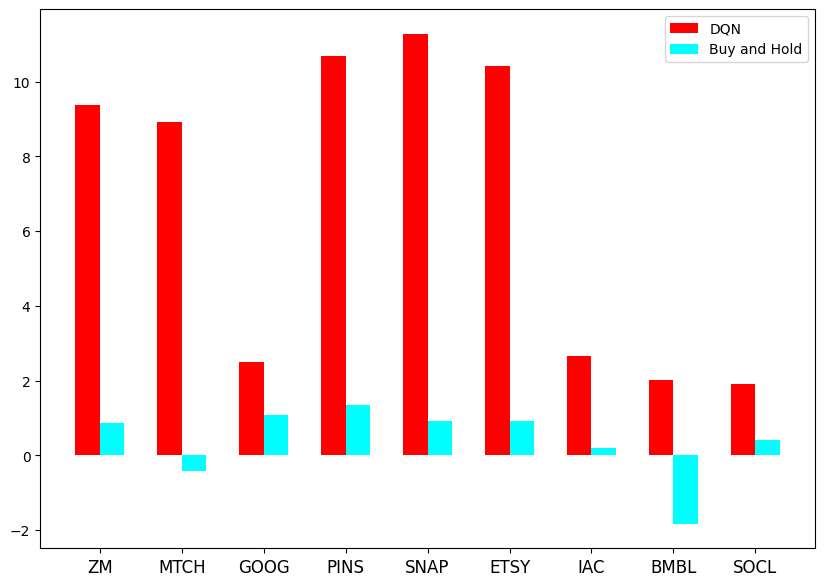

In [ ]:
# Author: Sreejeet Maity
import os
import sys
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ======================== Threshold Function ========================
def compute_G_t(t, R, C, epsilon, delta_1):
    """
    Computes a threshold value for the robust reward estimator.

    Parameters:
    - t: current number of reward observations in the buffer
    - R: reward scale (typically maximum absolute reward)
    - C: constant multiplier
    - epsilon: contamination parameter (used in robust estimation)
    - delta_1: probability parameter

    Returns:
    - G_t: threshold value
    """
    T_lim = 2 * np.log(4 / delta_1) + 1
    if t <= T_lim:
        return 2 * R
    else:
        return C * R * (np.sqrt(np.log(4 / delta_1) / t) + np.sqrt(epsilon)) + R

# ======================== Robust Trimmed Mean Estimator ========================
def univariate_trimmed_mean(Z, Z_tilde, epsilon, delta):
    """
    Robust reward estimator based on trimmed mean.

    Parameters:
    - Z: list of reward observations used for quantile estimation (length M/2)
    - Z_tilde: list of reward observations for averaging (length M/2)
    - epsilon: contamination parameter
    - delta: probability parameter

    Returns:
    - hat_mu_T: robust mean estimate
    """
    M = len(Z) + len(Z_tilde)
    assert len(Z) == len(Z_tilde) == M // 2, "Z and Z_tilde must both have M/2 elements."

    # Step 1: Set ζ = 8ε + 24 log(4/δ) / M
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M
    zeta = min(zeta, 1)  # Ensure ζ does not exceed 1

    # Step 2: Compute quantiles γ and β
    Z_sorted = np.sort(Z)
    gamma_index = int(np.floor(zeta * (M // 2)))
    beta_index = int(np.floor((1 - zeta) * (M // 2)))
    gamma_index = min(gamma_index, len(Z_sorted) - 1)
    beta_index = min(beta_index, len(Z_sorted) - 1)
    gamma = Z_sorted[gamma_index]
    beta = Z_sorted[beta_index]

    # Step 3: Compute robust mean estimate
    def phi_gamma_beta(x, gamma, beta):
        return min(max(x, gamma), beta)

    trimmed_sum = sum(phi_gamma_beta(x, gamma, beta) for x in Z_tilde)
    hat_mu_T = (2 / M) * trimmed_sum
    return hat_mu_T

# ======================== Neural Network Model ========================
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ======================== Replay Buffer ========================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# ======================== DQN Agent ========================
class DQN:
    def __init__(self, state_dim, action_dim, cfg):
        self.action_dim = action_dim
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.frame_idx = 0
        self.epsilon = lambda frame_idx: cfg.epsilon_end + (cfg.epsilon_start - cfg.epsilon_end) * math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size

        self.policy_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)

        # Robust reward estimation buffers: for each (state, action) pair.
        self.Z = {}         # Buffer for quantile estimation
        self.Z_tilde = {}   # Buffer for averaging
        self.robust_buffer_len = 10   # fixed number of reward samples to use
        self.robust_epsilon = 0.1     # contamination parameter for robust estimator
        self.robust_delta = 0.1       # delta parameter for robust estimator
        self.R_threshold = cfg.R_threshold  # reward scale parameter (maximum absolute reward)
        self.C_threshold = cfg.C_threshold  # constant multiplier for threshold
        self.delta_1 = cfg.delta_1          # delta parameter for threshold function

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state_tensor = torch.tensor([state], device=self.device, dtype=torch.float32)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.action_dim)

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)

        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def save(self, path):
        torch.save(self.target_net.state_dict(), os.path.join(path, 'dqn_checkpoint.pth'))

    def load(self, path):
        self.target_net.load_state_dict(torch.load(os.path.join(path, 'dqn_checkpoint.pth')))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)

# ======================== Trading Environment with Corrupted Rewards ========================
class TradingSystem_v1:
    def __init__(self, returns_data, k_value, mode, rho=0.1, corruption_type='random'):
        """
        Parameters:
        - returns_data: dict of {ticker: returns_series}
        - k_value: length of state (lookback window)
        - mode: 'train' or 'test'
        - rho: probability that the observed reward is corrupted
        - corruption_type: type of corruption ('random', 'flipped', 'scaled')
        """
        self.mode = mode
        self.index = 0
        self.data = returns_data
        self.tickers = list(returns_data.keys())
        self.current_stock = self.tickers[self.index]
        self.r_ts = self.data[self.current_stock]
        self.k = k_value
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.state = tuple(self.r_ts[:self.k])
        self.reward = 0.0
        self.is_terminal = False
        self.rho = 0.1
        self.corruption_type = corruption_type

    def corrupt_reward(self, true_reward):
        corruption_methods = {
            'random': lambda: random.uniform(-1, 1),
            'flipped': lambda: 0.7*true_reward,
            'scaled': lambda: true_reward * random.uniform(0.5, 1.5)
        }
        return corruption_methods.get(self.corruption_type, lambda: true_reward)()

    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
            self.is_terminal = True
        # Compute the true reward: (action - 1) * return
        true_reward = (action - 1) * self.r_ts[self.current_step + self.k - 1]
        # With probability rho, corrupt the reward
        if random.random() < self.rho:
            self.reward = self.corrupt_reward(true_reward)
        else:
            self.reward = true_reward
        # Update state (using a sliding window)
        self.state = tuple(self.r_ts[self.current_step:(self.k + self.current_step)])
        return self.state, self.reward, self.is_terminal

    def reset(self):
        if self.mode == 'train':
            self.current_stock = random.choice(self.tickers)
        else:
            self.current_stock = self.tickers[self.index]
            self.index += 1
        self.r_ts = self.data[self.current_stock]
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.state = tuple(self.r_ts[:self.k])
        self.reward = 0.0
        self.is_terminal = False
        return self.state

# ======================== Configuration ========================
class Config:
    def __init__(self):
        self.algo_name = 'DQN'
        self.env_name = 'TradingSystem_v1'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 11
        self.train_eps = 200
        self.state_space_dim = 50  # lookback window length
        self.action_space_dim = 3  # actions: short (0), neutral (1), long (2)

        self.gamma = 0.95
        self.epsilon_start = 0.90
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001
        self.memory_capacity = 1000
        self.batch_size = 64
        self.target_update = 4
        self.hidden_dim = 128

        # Set the corruption parameters here:
        self.rho = 0.001  # probability to observe a corrupted reward
        self.corruption_type = 'flipped'  # flip the sign of the true reward when corrupted

        # Parameters for thresholding the robust reward
        self.R_threshold = 10.0   # expected reward scale (e.g., maximum absolute reward)
        self.C_threshold = 10.0   # constant multiplier for threshold
        self.delta_1 = 0.1       # delta parameter for threshold function

        curr_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        try:
            curr_path = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            curr_path = os.getcwd()
        self.result_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "results")
        self.model_path = os.path.join(curr_path, "outputs", self.env_name, curr_time, "models")
        self.save = True

# ======================== Environment and Agent Setup ========================
def env_agent_config(data, cfg, mode):
    env = TradingSystem_v1(data, cfg.state_space_dim, mode, rho=cfg.rho, corruption_type=cfg.corruption_type)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)
    if cfg.seed != 0:
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)
        random.seed(cfg.seed)
    return env, agent

# ======================== Training Loop ========================
def train(cfg, env, agent):
    rewards = []
    ma_rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            # --- Robust Reward Estimation using Univariate Trimmed Mean and Thresholding ---
            # Use a (state, action) key to maintain reward buffers.
            key = (tuple(state), action)
            if key not in agent.Z:
                agent.Z[key] = []
                agent.Z_tilde[key] = []
            agent.Z[key].append(reward)
            agent.Z_tilde[key].append(reward)
            # Truncate buffers to maintain fixed size.
            if len(agent.Z[key]) > agent.robust_buffer_len:
                agent.Z[key] = agent.Z[key][-agent.robust_buffer_len:]
                agent.Z_tilde[key] = agent.Z_tilde[key][-agent.robust_buffer_len:]
            # Compute robust reward only when the buffer is full; otherwise, fallback to raw reward.
            if len(agent.Z[key]) == agent.robust_buffer_len:
                robust_reward = univariate_trimmed_mean(agent.Z[key], agent.Z_tilde[key],
                                                        agent.robust_epsilon, agent.robust_delta)
                # Use threshold function to clip the robust reward.
                t_val = len(agent.Z[key])
                G_threshold = compute_G_t(t_val, agent.R_threshold, agent.C_threshold,
                                          agent.robust_epsilon, agent.delta_1)
                robust_reward = np.clip(robust_reward, -G_threshold, G_threshold)
            else:
                robust_reward = reward
            # -------------------------------------------------------------------------

            agent.memory.push(state, action, robust_reward, next_state, done)
            agent.update()
            ep_reward += reward  # (logging raw reward for evaluation)
            state = next_state
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"Episode: {i_ep+1}/{cfg.train_eps}, Reward: {ep_reward:.2f}")
    return rewards, ma_rewards

# ======================== Testing Loop ========================
def test(cfg, env, agent):
    print("Start Testing!")
    # Disable exploration during testing.
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0
    stocks = env.tickers
    rewards = []
    for i_ep in range(len(stocks)):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break
        rewards.append(ep_reward)
        print(f"Test Episode: {i_ep+1}/{len(stocks)}, Reward: {ep_reward:.2f}")
    return stocks, rewards

# ======================== Main Script ========================
if __name__ == "__main__":
    # Define tickers and time range for training and testing.
    train_tickers = ['ZM', 'TWTR', 'FB', 'MTCH', 'GOOG', 'PINS', 'SNAP', 'ETSY']
    test_tickers = ['IAC', 'ZNGA', 'BMBL', 'SOCL']
    start_date = dt.date(2020, 1, 1)
    end_date = dt.datetime.today().strftime('%Y-%m-%d')

    # Download training data.
    train_data = {}
    for ticker in train_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        train_data[ticker] = returns

    # Download testing data.
    test_data = {}
    for ticker in test_tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            continue
        if data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue
        if 'Adj Close' in data.columns:
            returns = data['Adj Close'].pct_change().dropna().values.flatten().tolist()
        elif 'Close' in data.columns:
            returns = data['Close'].pct_change().dropna().values.flatten().tolist()
        else:
            print(f"Neither 'Adj Close' nor 'Close' found for {ticker}. Skipping...")
            continue
        test_data[ticker] = returns

    # Combine train and test data for the testing environment.
    all_data = {**train_data, **test_data}

    # Create configuration, directories, and initialize environment/agent for training.
    cfg = Config()
    os.makedirs(cfg.result_path, exist_ok=True)
    os.makedirs(cfg.model_path, exist_ok=True)

    # Training.
    env, agent = env_agent_config(train_data, cfg, mode='train')
    rewards, ma_rewards = train(cfg, env, agent)
    agent.save(path=cfg.model_path)

    # Plot training results.
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, cfg.train_eps + 1), rewards, label='Rewards', color='blue')
    plt.plot(range(1, cfg.train_eps + 1), ma_rewards, label='Moving Average Rewards', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.savefig(os.path.join(cfg.result_path, 'train.jpg'))

    # Testing.
    env, agent = env_agent_config(all_data, cfg, mode='test')
    agent.load(path=cfg.model_path)
    stocks, test_rewards = test(cfg, env, agent)
    buy_and_hold_rewards = [sum(all_data[stock]) for stock in stocks]

    # Plot testing results.
    plt.figure(figsize=(10, 7))
    width = 0.3
    x = np.arange(len(stocks))
    plt.bar(x, test_rewards, width=width, label='DQN', color='red')
    plt.bar(x + width, buy_and_hold_rewards, width=width, label='Buy and Hold', color='cyan')
    plt.xticks(x + width / 2, stocks, fontsize=12)
    plt.legend()
    plt.savefig(os.path.join(cfg.result_path, 'test.jpg'))
